# Data Ingestion for Credit Risk Engine


Load libraries

In [1]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We load the data from kaggle

In [2]:
dataset_name = "laotse/credit-risk-dataset"
zip_file = "credit-risk-dataset.zip"
extract_path = "../data"

!kaggle datasets download -d {dataset_name} -p {extract_path} --unzip

Dataset URL: https://www.kaggle.com/datasets/laotse/credit-risk-dataset
License(s): CC0-1.0
100%|████████████████████████████████████████| 368k/368k [00:00<00:00, 1.91MB/s]



In [3]:
sns.set_palette("Set2")

And load the csv file downloaded

In [4]:
df = pd.read_csv(f"{extract_path}/credit_risk_dataset.csv")
df.shape

(32581, 12)

Data has 32581 observations with 12 features

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


We can see that we have some numerical features such as person_age, person_income, person_emp_length, loan_amnt, loan_int_rate, loan_percent_income, cb_person_cred_hist_length and some categorical features such as person_home_ownership, loan_intent, loan_grade, cb_person_default_on_file.

The target variable is loan_status which is binary (0 or 1).

In [6]:
df.describe(include='all')

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581,31686.000000,32581,32581,32581.000000,29465.000000,32581.000000,32581.000000,32581,32581.000000
unique,NaN,NaN,4,NaN,6,7,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,RENT,NaN,EDUCATION,A,NaN,NaN,NaN,NaN,N,NaN
freq,NaN,NaN,16446,NaN,6453,10777,NaN,NaN,NaN,NaN,26836,NaN
mean,27.734600,6.607485e+04,NaN,4.789686,NaN,NaN,9589.371106,11.011695,0.218164,0.170203,NaN,5.804211
std,6.348078,6.198312e+04,NaN,4.142630,NaN,NaN,6322.086646,3.240459,0.413006,0.106782,NaN,4.055001
min,20.000000,4.000000e+03,NaN,0.000000,NaN,NaN,500.000000,5.420000,0.000000,0.000000,NaN,2.000000
25%,23.000000,3.850000e+04,NaN,2.000000,NaN,NaN,5000.000000,7.900000,0.000000,0.090000,NaN,3.000000
50%,26.000000,5.500000e+04,NaN,4.000000,NaN,NaN,8000.000000,10.990000,0.000000,0.150000,NaN,4.000000
75%,30.000000,7.920000e+04,NaN,7.000000,NaN,NaN,12200.000000,13.470000,0.000000,0.230000,NaN,8.000000


As we can see there are some inconsistencies on some features like 'person_age' of 144 years or 'person_emp_length' of 123 years so we handle that

In [7]:
# As we can see there are some inconsistencies on some features like 'person_age' of 144 years or 'person_emp_length' of 123 years
df_cleaned = df[df['person_age'] < 100].copy()
df_cleaned = df_cleaned[df_cleaned['person_emp_length'] <= 60]

In [8]:
# Check for missing values
null_counts = df.isnull().sum()
null_percentages = (null_counts / len(df)) * 100
null_report = pd.DataFrame({'Null': null_counts, 'Percent (%)': null_percentages})
print(null_report[null_report['Null'] > 0])

                   Null  Percent (%)
person_emp_length   895     2.747000
loan_int_rate      3116     9.563856


Null values are on person_emp_length that couldd be due to the fact that the person is unemployed so we can fill those null values with 0. And we can also fill the null values on 'loan_int_rate' with the median of the column.

In [9]:
df_cleaned['person_emp_length'] = df_cleaned['person_emp_length'].fillna(0)
df_cleaned['loan_int_rate'] = df_cleaned['loan_int_rate'].fillna(df_cleaned['loan_int_rate'].median())

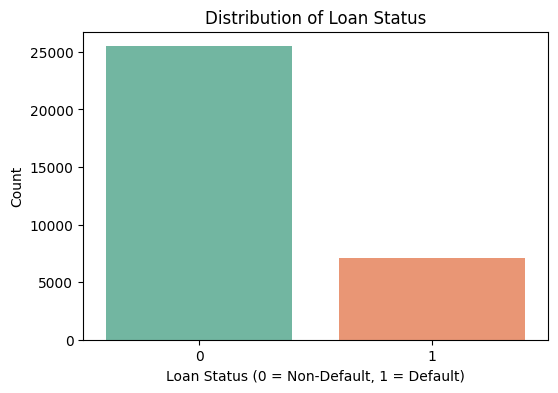

Default rate on the dataframe: 21.82%


In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status (0 = Non-Default, 1 = Default)')
plt.ylabel('Count')
plt.show()

default_rate = df['loan_status'].mean() * 100
print(f"Default rate on the dataframe: {default_rate:.2f}%")

We can see that the target variable is imbalanced, with a default rate of around 20%. This will require handling during model training to ensure that the model does not become biased towards the majority class.

Before saving the cleaned dataset we put the target variable at the end of the dataframe for better readability on the following steps of the project.

In [11]:
df_cleaned['loan_status'] = df_cleaned.pop('loan_status')

In [12]:
df_cleaned.to_csv('../data/credit_risk_cleaned.csv', index=False)